In [27]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from wbfm.utils.projects.finished_project_data import ProjectData
import napari
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from collections import defaultdict
import zarr
from pathlib import Path
import os
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from sklearn.decomposition import PCA
from wbfm.utils.visualization.plot_traces import make_grid_plot_from_dataframe
import seaborn as sns
import surpyval
import plotly.express as px

In [3]:
# fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-27_spacer_7b_2per_agar/ZIM2165_Gcamp7b_worm1-2022_11_28/project_config.yaml"
# Manually corrected version
fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/paper_data/ZIM2165_Gcamp7b_worm1-2022_11_28/project_config.yaml"
project_data_gcamp = ProjectData.load_final_project_data_from_config(fname)

ConfigFile  : INFO     =======================================
Project data for directory:
/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/paper_data/ZIM2165_Gcamp7b_worm1-2022_11_28 
With raw data in directory:
/scratch/neurobiology/zimmer/ulises/wbfm/20221127/data/ZIM2165_Gcamp7b_worm1/2022-11-27_15-14_ZIM2165_worm1_GC7b_Ch0-BH 

Found the following data files:
============Raw========================
red_data:                 True
green_data:               True
============Annotations================
manual_tracking:          True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     False
============Traces=====================
traces:                   True



In [4]:
# Load multiple datasets
from wbfm.utils.visualization.hardcoded_paths import load_paper_datasets
all_projects_gcamp = load_paper_datasets('gcamp')
all_projects_gfp = load_paper_datasets('gfp')


  0%|          | 0/23 [00:00<?, ?it/s]

Loaded 23 projects


  0%|          | 0/8 [00:00<?, ?it/s]

Loaded 8 projects


In [28]:
output_folder = "multiproject_behavior_quantifications"

# Histograms of several statistics

## Displacement

In [29]:
from collections import defaultdict

def calc_net_displacement(p):
    # Units: mm
    i_seg = 50

    df = p.worm_posture_class.centerline_absolute_coordinates()
    xy0 = df.loc[0, :][i_seg]
    xy1 = df.iloc[-1, :][i_seg]
    
    return np.linalg.norm(xy0 - xy1)
    
def calc_cumulative_displacement(p):
    # Units: mm
    i_seg = 50

    df = p.worm_posture_class.centerline_absolute_coordinates()[i_seg]
    dist = np.sqrt((df['X'] - df['X'].shift())**2 + (df['Y'] - df['Y'].shift())**2)
    line_integral = np.nansum(dist)
    
    return line_integral

def calc_displacement_dataframes(all_projects):
    
    all_displacements = defaultdict(dict)
    for name, p in tqdm(all_projects.items()):
        all_displacements['net'][name] = calc_net_displacement(p)
        all_displacements['cumulative'][name] = calc_cumulative_displacement(p)
    df_displacement_gcamp = pd.DataFrame(all_displacements)
    
    return df_displacement_gcamp

In [6]:
df_displacement_gcamp = calc_displacement_dataframes(all_projects_gcamp)
df_displacement_gfp = calc_displacement_dataframes(all_projects_gfp)


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [31]:
df_displacement_gfp.shape

(8, 3)

In [32]:
df_displacement_gcamp['genotype'] = 'gcamp'
df_displacement_gfp['genotype'] = 'gfp'

df_displacement = pd.concat([df_displacement_gcamp, df_displacement_gfp])

In [33]:
# fig = px.histogram(df_displacement, x='net', color='genotype', nbins=40)

# fig.update_layout(barmode='stack')
# # fig.update_traces(opacity=0.75)

# fig.show()

In [35]:
# fig = px.histogram(df_displacement, x='net', facet_row='genotype', color='genotype', nbins=30)
# fig.show()

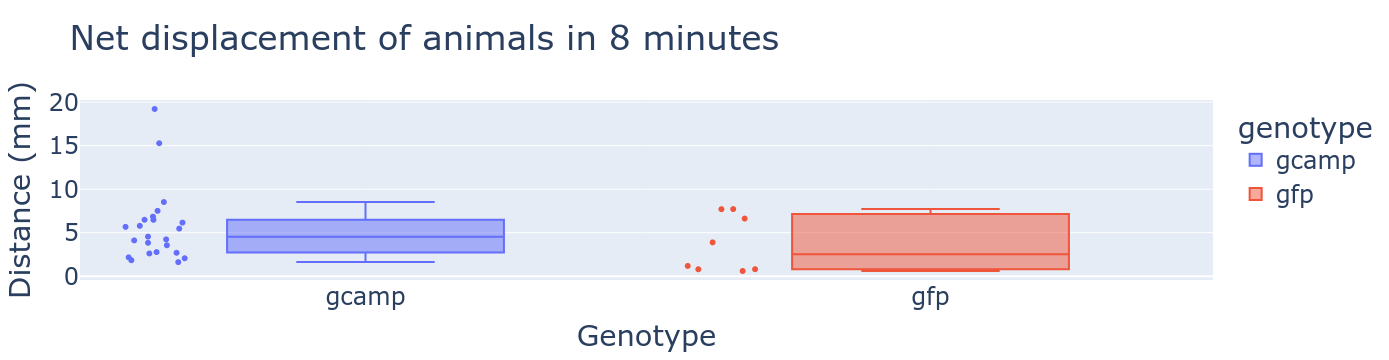

In [161]:
# Alternative: boxplot with scatter plot
fig = px.box(df_displacement, y='net', x='genotype', color='genotype', points='all', title="Net displacement of animals in 8 minutes")
fig.update_layout(yaxis=dict(title='Distance (mm)'), xaxis=dict(title='Genotype'))

fig.update_layout(
    font=dict(size=24)
)
fig.show()

fname = "net_displacement.png"
fname = os.path.join(output_folder, fname)
fig.write_image(fname)

fig.write_image(fname.replace(".png", ".svg"))

In [42]:
# fig = px.histogram(df_displacement, x='cumulative', facet_row='genotype', color='genotype', nbins=30)
# fig.show()

## Speed, in several different ways

In [165]:
from wbfm.utils.visualization.plot_summary_statistics import calc_speed_dataframe

In [166]:
df_speed_gcamp = calc_speed_dataframe(all_projects_gcamp)
df_speed_gfp = calc_speed_dataframe(all_projects_gfp)

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [167]:
df_speed_gcamp['genotype'] = 'gcamp'
df_speed_gfp['genotype'] = 'gfp'

df_speed = pd.concat([df_speed_gcamp, df_speed_gfp])

In [168]:
df_speed

dataset_name  abs_stage_speed  middle_body_speed  \
0                  2022-11-23_worm8              NaN                NaN   
1                  2022-11-23_worm8              NaN                NaN   
2                  2022-11-23_worm8         0.102022           0.080678   
3                  2022-11-23_worm8         0.064431           0.050660   
4                  2022-11-23_worm8         0.057088           0.044963   
...                             ...              ...                ...   
13331  ZIM2319_GFP_worm8-2022-12-10         0.081850           0.078627   
13332  ZIM2319_GFP_worm8-2022-12-10         0.091936           0.075537   
13333  ZIM2319_GFP_worm8-2022-12-10         0.098216           0.076574   
13334  ZIM2319_GFP_worm8-2022-12-10         0.094315           0.078018   
13335  ZIM2319_GFP_worm8-2022-12-10         0.084275           0.073561   

       signed_middle_body_speed  worm_speed_average_all_segments genotype  
0                           NaN                         0.066177    gcamp  
1                           NaN                         0.077058    gcamp  
2                     -0.080678                         0.073708    gcamp  
3                     -0.050660                         0.049456    gcamp  
4                     -0.044963                         0.036365    gcamp  
...                         ...                              ...      ...  
13331                  0.078627                         0.082882      gfp  
13332                  0.075537                         0.080790      gfp  
13333                  0.076574                         0.082360      gfp  
13334                  0.078018                         0.082821      gfp  
13335                  0.073561                         0.078184      gfp  

[51677 rows x 6 columns]

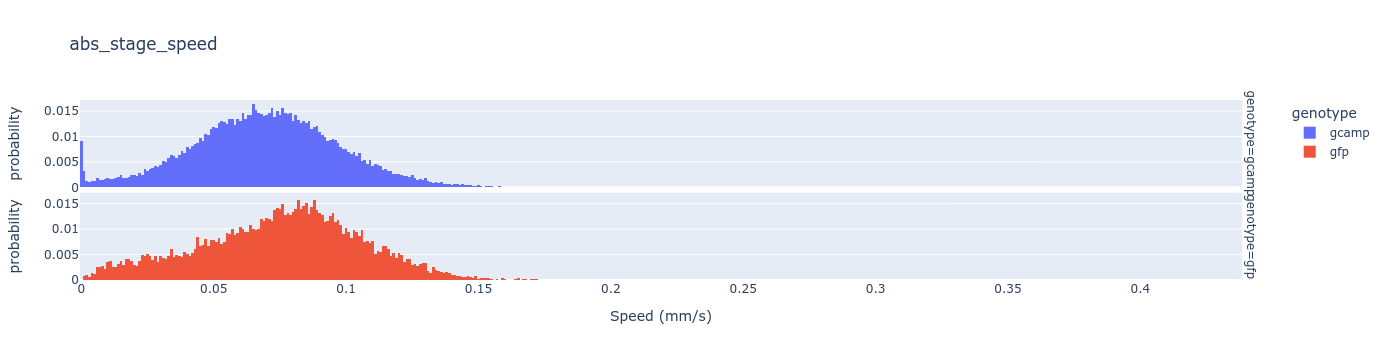

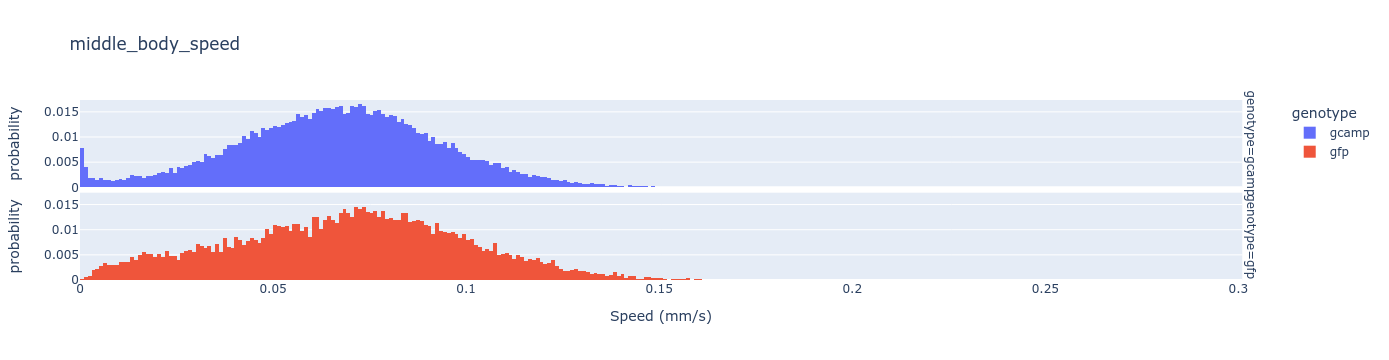

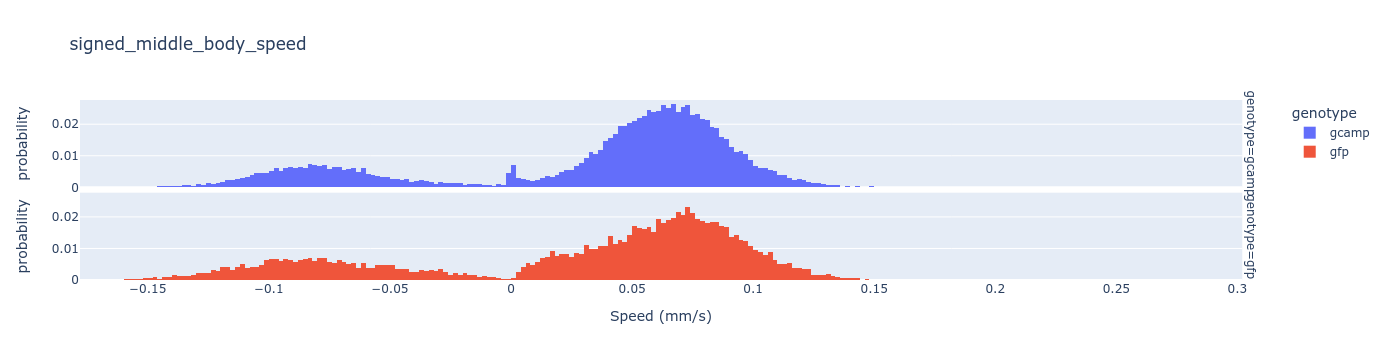

In [174]:
# TODO: trace of hist (fewer bins), with error bars and gray with individual traces
# TODO: OR: normaly histogram, but boxplot per individual of rectified speeds


speed_types = ['abs_stage_speed', 'middle_body_speed', 'signed_middle_body_speed']
for x in speed_types:
    fig = px.histogram(df_speed, x=x, facet_row='genotype', color='genotype', title=x, histnorm='probability')
    fig.update_layout(
        xaxis_title="Speed (mm/s)"
    )
    fig.show()
    
    fname = f"{x}_histogram.png"
    fname = os.path.join(output_folder, fname)
    fig.write_image(fname)
    fig.write_image(fname.replace(".png", ".svg"))

In [ ]:
# fig.update_layout(title='Speed')
    

## Reversal and forward durations

In [18]:
from wbfm.utils.visualization.plot_summary_statistics import calc_durations_dataframe

In [19]:
df_duration_gcamp = calc_durations_dataframe(all_projects_gcamp)
df_duration_gfp = calc_durations_dataframe(all_projects_gfp)

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [20]:
# %debug

In [151]:
df_duration_gcamp['genotype'] = 'gcamp'
df_duration_gfp['genotype'] = 'gfp'

df_duration = pd.concat([df_duration_gcamp, df_duration_gfp])

fps = 3.5
df_duration['BehaviorCodes.FWD'] /= fps
df_duration['BehaviorCodes.REV'] /= fps

In [152]:
df_duration.columns

Index(['dataset_name', 'BehaviorCodes.FWD', 'BehaviorCodes.REV', 'genotype'], dtype='object')

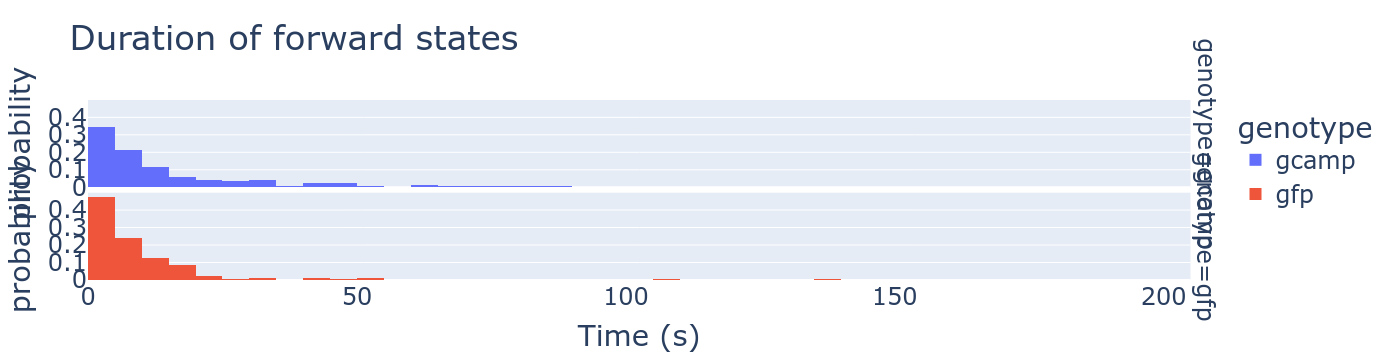

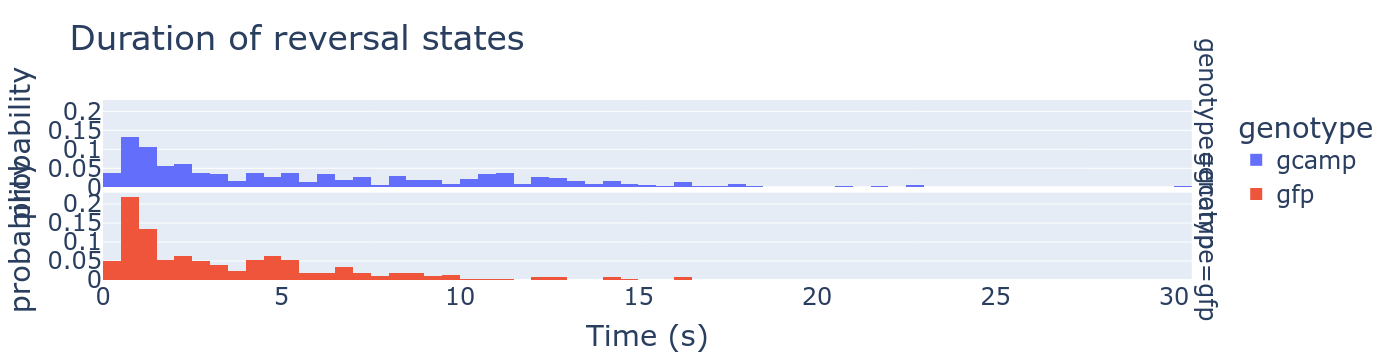

In [164]:

states = ['BehaviorCodes.FWD', 'BehaviorCodes.REV']
titles = ["forward", "reversal"]

for x, t in zip(states, titles):
    fig = px.histogram(df_duration, x=x, facet_row='genotype', color='genotype', title=f"Duration of {t} states", histnorm='probability')
    
    fig.update_layout(
        font=dict(size=24)
    )
    fig.update_layout(
        xaxis_title="Time (s)"
    )
    fig.show()
    
    fname = f"duration_histogram_{x.split('.')[1]}.png"
    fname = os.path.join(output_folder, fname)
    fig.write_image(fname)
    fig.write_image(fname.replace(".png", ".svg"))

## Reversal and forward frequency

# Histogram of post-reversal head bend peaks

In [115]:
# For each project, get the positive and negative post reversal peaks
# Use the summed signed head curvature

final_ventral_dict = {}
final_dorsal_dict = {}

for name, p in tqdm(all_projects_gcamp.items()):

    worm = p.worm_posture_class
    y_curvature = worm.calc_behavior_from_alias('head_signed_curvature')

    ventral_peaks, ventral_peak_times, _ = worm.get_peaks_post_reversal(y_curvature, num_points_after_reversal=20)
    dorsal_peaks, dorsal_peak_times, all_rev_ends = worm.get_peaks_post_reversal(-y_curvature, num_points_after_reversal=20)

    # Keep the positive peak if it is a ventral turn at that time, or negative peak if it is dorsal
    # ... actually I don't think Ulises' annotations are that frame-accurate, so I will take whichever peak is closer to the end of the reversal, i.e. the first body bend
    ventral_to_keep = []
    dorsal_to_keep = []
    for vp, vt, dp, dt, end in zip(ventral_peaks, ventral_peak_times, dorsal_peaks, dorsal_peak_times, all_rev_ends):
        # Alternate: take the one with the higher amplitude
        # if np.abs(vp) > np.abs(dp):
        #     ventral_to_keep.append(vp)
        # else:
        #     dorsal_to_keep.append(dp)
        
        # Skip if the event is exactly at the end
#         vt_at_edge = vt == end
#         vt_early = vt < dt
#         dt_at_edge = dt == end
        
        if vt < dt and vt > end:
            ventral_to_keep.append(vp)
        elif dt > end:
            dorsal_to_keep.append(-dp)
        else:
            pass
    final_ventral_dict[name] = ventral_to_keep
    final_dorsal_dict[name] = dorsal_to_keep

  0%|          | 0/23 [00:00<?, ?it/s]

In [116]:
# For now, ignore the dataset they came from
df_ventral = pd.DataFrame(np.concatenate(list(final_ventral_dict.values())))
df_ventral['Turn Direction'] = 'Ventral'
df_dorsal = pd.DataFrame(np.concatenate(list(final_dorsal_dict.values())))
df_dorsal['Turn Direction'] = 'Dorsal'

df_turns = pd.concat([df_ventral, df_dorsal])
df_turns.columns = ['Amplitude', 'Turn Direction']

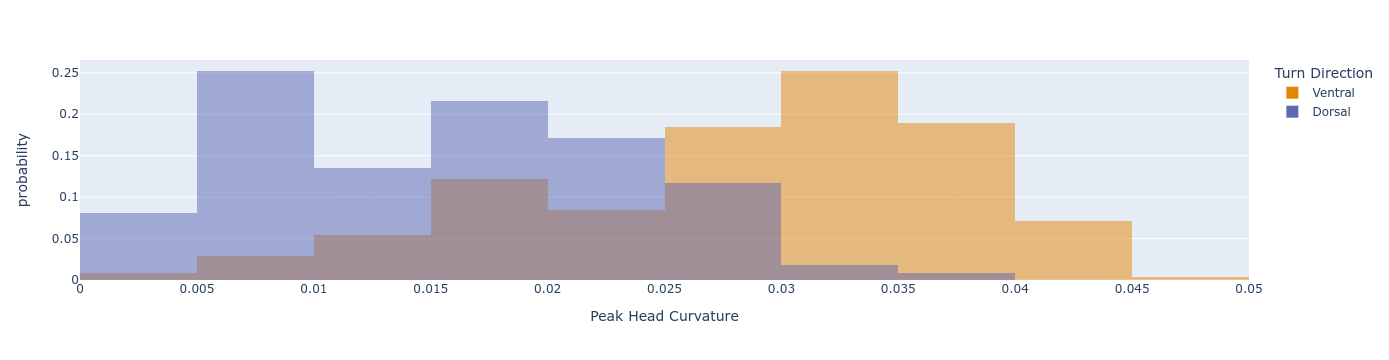

In [179]:
df_turns['Amplitude'] = df_turns['Amplitude'].abs()

fig = px.histogram(df_turns, color="Turn Direction", histnorm='probability', color_discrete_sequence=px.colors.qualitative.Vivid,
                  barmode='overlay')
fig.update_layout(xaxis=dict(title="Peak Head Curvature"))
fig.show()


fname = f"first_head_bend_absolute_curvature_histogram.png"
fname = os.path.join(output_folder, fname)
fig.write_image(fname)
fig.write_image(fname.replace(".png", ".svg"))

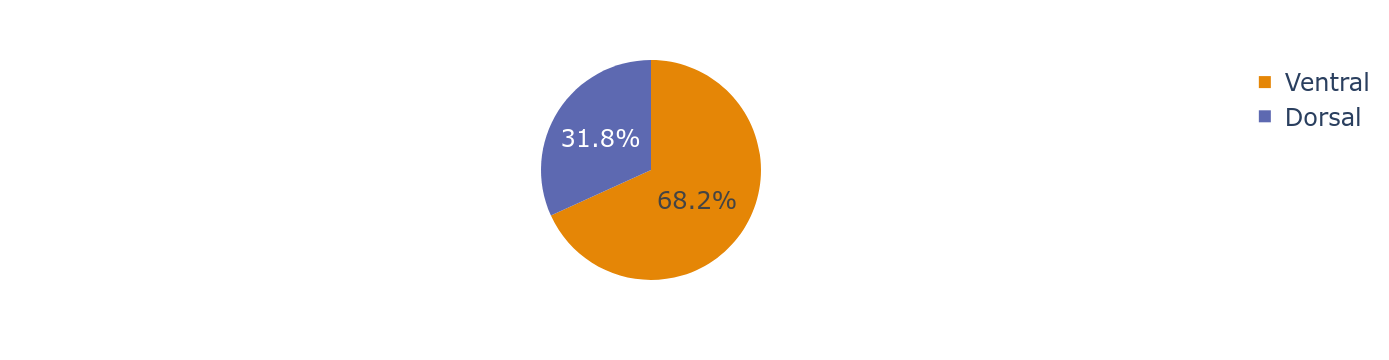

In [145]:
fig = px.pie(df_turns, names="Turn Direction", color_discrete_sequence=px.colors.qualitative.Vivid)

fig.update_layout(
    font=dict(
        size=24,  # Set the font size here
    ),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.show()

fname = f"first_head_bend_absolute_curvature_pie_chart.png"
fname = os.path.join(output_folder, fname)
fig.write_image(fname)
fig.write_image(fname.replace(".png", ".svg"))

# Debug Behaviors

# Calculate the cumulative distribution of forward durations, including censoring information

In [7]:
duration_vec = []
censored_vec = []
for name, p in all_projects_gcamp.items():
    ind_class = p.worm_posture_class.calc_triggered_average_indices(ind_preceding=0, min_duration=0)
    d, c = ind_class.all_durations_with_censoring()
    duration_vec.extend(d)
    censored_vec.extend(c)

Parametric SurPyval Model
Distribution        : Weibull
Fitted by           : MLE
Parameters          :
     alpha: 34.37252347242135
      beta: 0.6320770854810925
5631.464000724836


<AxesSubplot: title={'center': 'Weibull Probability Plot'}, ylabel='CDF'>

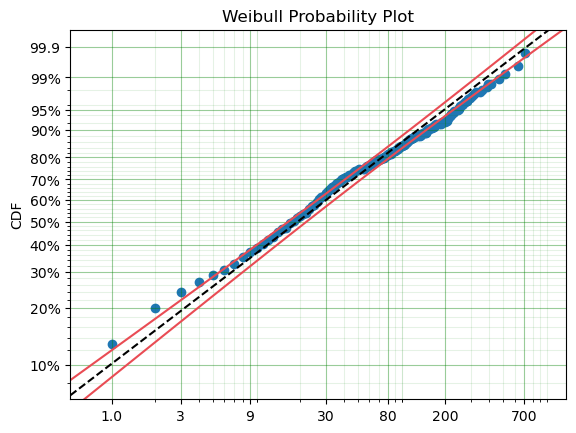

In [8]:
# With censoring
model = surpyval.Weibull.fit(x=duration_vec, c=censored_vec)
print(model)
print(model.aic())
model.plot()

In [9]:
# Package everything for saving
import pickle
y_dat, x_dat = np.histogram(duration_vec, bins=np.arange(1000))
x_dat = x_dat[:-1]
y_dat = np.cumsum(y_dat / np.sum(y_dat))

out = dict(duration_vec=duration_vec, censored_vec=censored_vec, 
           x_dat=x_dat, y_dat=y_dat,
           alpha=model.alpha, beta=model.beta, model_dict=model.to_dict())

foldername = "/scratch/neurobiology/zimmer/wbfm/DistributionsOfBehavior"
fname = os.path.join(foldername, 'forward_duration.pickle')

with open(fname, 'wb') as f:
    pickle.dump(out, f)

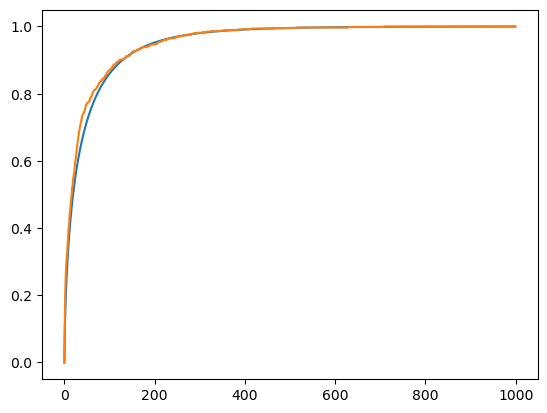

In [11]:
x = np.arange(1000)
y = model.ff(x)

y_dat, x_dat = np.histogram(duration_vec, bins=np.arange(1000))
x_dat = x_dat[:-1]
y_dat = np.cumsum(y_dat / np.sum(y_dat))

plt.plot(y)
plt.plot(x_dat, y_dat)

## Same but for reversal distribution

In [15]:
from wbfm.utils.external.utils_behavior_annotation import BehaviorCodes

In [16]:
duration_vec = []
censored_vec = []
for name, p in all_projects_gcamp.items():
    ind_class = p.worm_posture_class.calc_triggered_average_indices(ind_preceding=0, min_duration=0, state=BehaviorCodes.REV)
    d, c = ind_class.all_durations_with_censoring()
    duration_vec.extend(d)
    censored_vec.extend(c)

Parametric SurPyval Model
Distribution        : Weibull
Fitted by           : MLE
Parameters          :
     alpha: 13.177889522027668
      beta: 0.7853707750708078
4324.428789034805


<AxesSubplot: title={'center': 'Weibull Probability Plot'}, ylabel='CDF'>

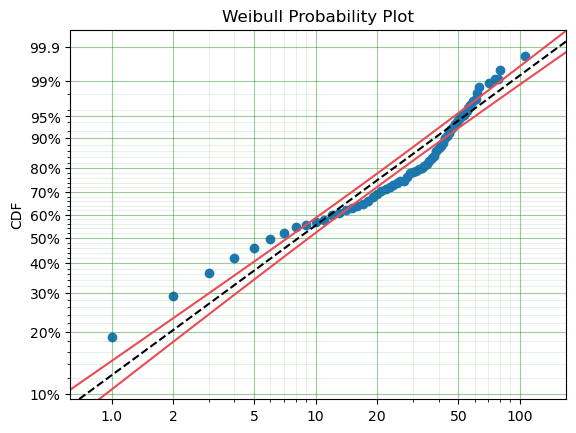

In [21]:
# With censoring
model = surpyval.Weibull.fit(x=duration_vec, c=censored_vec)
print(model)
print(model.aic())
model.plot()

In [22]:
# Package everything for saving
import pickle
y_dat, x_dat = np.histogram(duration_vec, bins=np.arange(1000))
x_dat = x_dat[:-1]
y_dat = np.cumsum(y_dat / np.sum(y_dat))

out = dict(duration_vec=duration_vec, censored_vec=censored_vec, 
           x_dat=x_dat, y_dat=y_dat,
           alpha=model.alpha, beta=model.beta, model_dict=model.to_dict())

foldername = "/scratch/neurobiology/zimmer/wbfm/DistributionsOfBehavior"
fname = os.path.join(foldername, 'reversal_duration.pickle')

with open(fname, 'wb') as f:
    pickle.dump(out, f)

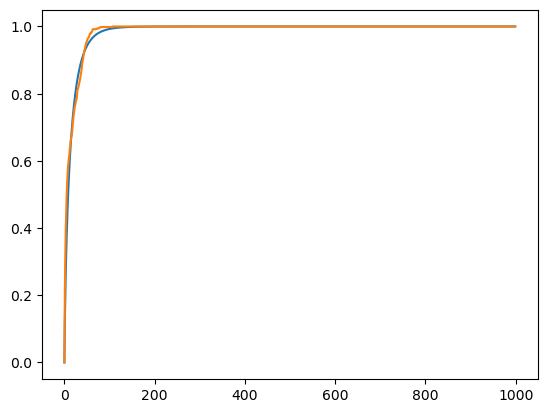

In [23]:
x = np.arange(1000)
y = model.ff(x)

y_dat, x_dat = np.histogram(duration_vec, bins=np.arange(1000))
x_dat = x_dat[:-1]
y_dat = np.cumsum(y_dat / np.sum(y_dat))

plt.plot(y)
plt.plot(x_dat, y_dat)

Parametric SurPyval Model
Distribution        : Exponential
Fitted by           : MLE
Parameters          :
    lambda: 0.06659905341461796
4386.114728977719


<AxesSubplot: title={'center': 'Exponential Probability Plot'}, ylabel='CDF'>

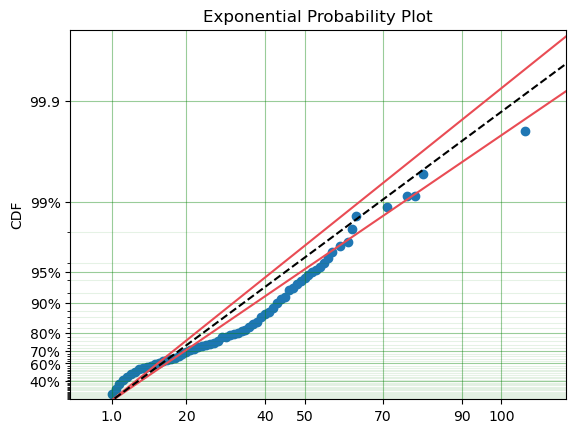

In [40]:
# With censoring
model = surpyval.Exponential.fit(x=duration_vec, c=censored_vec)
print(model)
print(model.aic())
model.plot()

# Scratch: other distributions

Parametric SurPyval Model
Distribution        : Exponential
Fitted by           : MLE
Parameters          :
    lambda: 0.020854806569092346
5914.387383266321


<AxesSubplot: title={'center': 'Exponential Probability Plot'}, ylabel='CDF'>

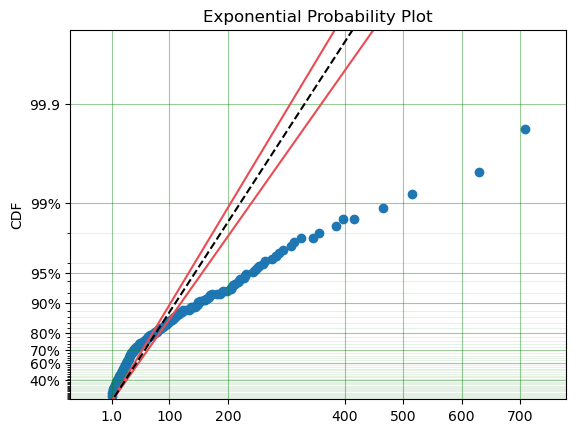

In [102]:

model = surpyval.Exponential.fit(x=duration_vec, c=censored_vec)
print(model)
print(model.aic())
model.plot()

Parametric SurPyval Model
Distribution        : Weibull
Fitted by           : MLE
Parameters          :
     alpha: 31.515902496100846
      beta: 0.6470469384054576
5956.798329255067


<AxesSubplot: title={'center': 'Weibull Probability Plot'}, ylabel='CDF'>

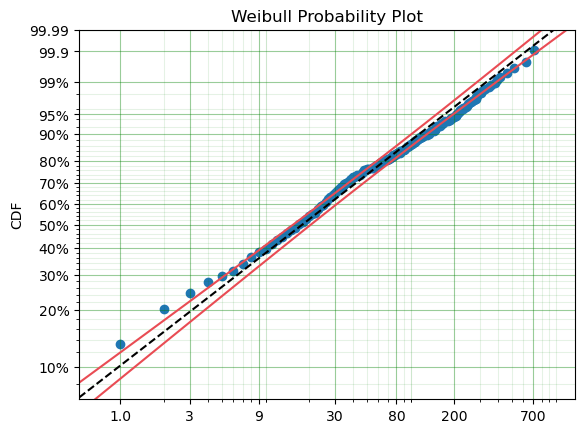

In [101]:
# NO CENSORING
import surpyval

model = surpyval.Weibull.fit(x=duration_vec)
print(model)
print(model.aic())
model.plot()

Parametric SurPyval Model
Distribution        : GompertzMakeham
Fitted by           : MLE
Parameters          :
    lambda: 14.76520305085028
     alpha: 1.765429771942359e-09
      beta: 4.7108083661632225
-2048.419745835553


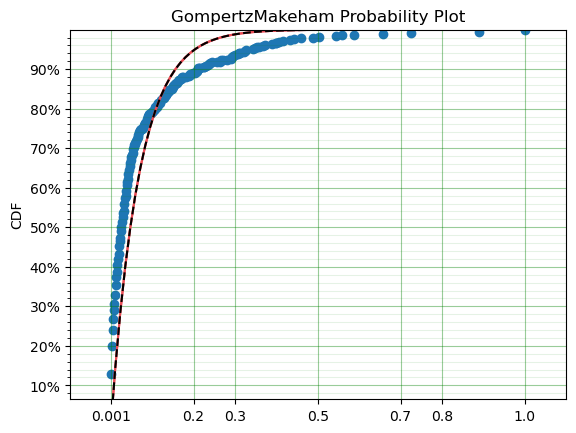

In [110]:
# See: https://surpyval.readthedocs.io/en/latest/applications.html
from autograd import numpy as np_auto

bounds = ((0, None), (0, None), (0, None),)
support = (0, np_auto.inf)
param_names = ['lambda', 'alpha', 'beta']
def Hf(x, *params):
    Hf = params[0] * x + (params[1]/params[2])*(np_auto.exp(params[2]*x))
    return Hf
GompertzMakeham = surpyval.Distribution('GompertzMakeham', Hf, param_names, bounds, support)

model = GompertzMakeham.fit(x=duration_vec / np.max(duration_vec), c=censored_vec, how='MLE')
model.plot(alpha_ci=0.95)
print(model)
print(model.aic())

Parametric SurPyval Model
Distribution        : double_exponential
Fitted by           : MLE
Parameters          :
    alpha1: 1.9131632240576027e-10
   lambda1: 0.01112822122612816
    alpha2: 0.5071105671904247
   lambda2: 4.659278245796474


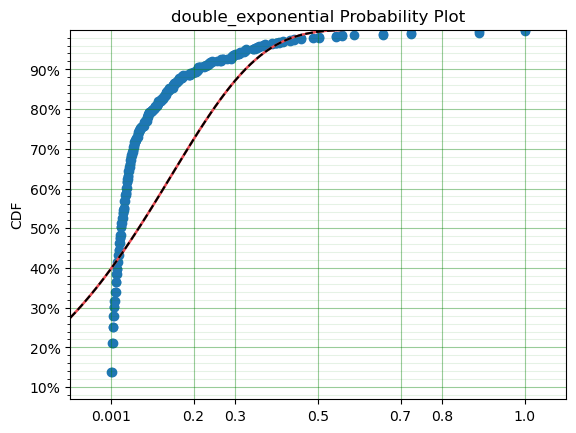

In [96]:
# See: https://surpyval.readthedocs.io/en/latest/applications.html
from autograd import numpy as np_auto

bounds = ((0, None), (0, None), (0, None), (0, None))
support = (0, np_auto.inf)
param_names = ['alpha1', 'lambda1', 'alpha2', 'lambda2']
def Hf(x, *params):
    Hf = params[0]*(np_auto.exp(params[1]*x)) + params[2]*(np_auto.exp(params[3]*x))
    return Hf
DoubleExponential = surpyval.Distribution('double_exponential', Hf, param_names, bounds, support)

# model = DoubleExponential.fit(x=duration_vec, c=censored_vec, init=initial)
initial = (0.5, 0.01, 0.5, 0.5)
model = DoubleExponential.fit(x=duration_vec / np.max(duration_vec), c=censored_vec, init=initial, how='MLE')
model.plot(alpha_ci=0.95, heuristic='Nelson-Aalen')
print(model)

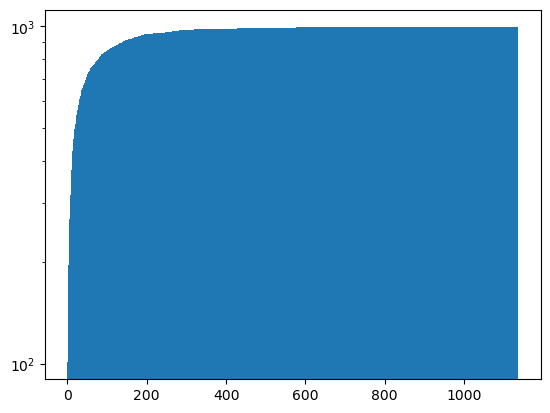

In [124]:
y = surpyval.Weibull.random(1000, 34, 0.63)
n = plt.hist(y, cumulative=True, bins=1000, log=True);